# Analysis of `wandb` Logs and Metrics
This notebook collects different metrics for a specified experiment.

# Setup

In [1]:
import numpy as np
import pprint
from typing import Literal, List

import warnings

warnings.filterwarnings("ignore")

import wandb

api = wandb.Api()

import pandas as pd


In [2]:
runs = api.runs("uedyiuajxz-personal/qfl-prod-le-2")

In [3]:
groups = list(set(run.config.get("group", None) for run in runs))
print(groups)

['Standard-fedqnn-14385575', 'FHE-fedqnn-14096295', 'FHE-fednn-14288052', 'Standard-resnet18-14166520', 'Standard-fedqnn-14378196', 'FHE-fednn-14385574', 'FHE-resnet18-qcnn-14602070', 'Standard-fednn-14096292', 'Standard-resnet18-qnn-14378202', 'Standard-resnet18-qcnn-14096302', 'FHE-resnet18-qcnn-14621587', 'Standard-fednn-14166514', 'Standard-fedqnn-14166516', 'Standard-resnet18-14385579', 'FHE-qcnn-14378199', 'FHE-resnet18-14378201', 'Standard-fednn-14378194', 'FHE-resnet18-qnn-14385582', 'Standard-resnet18-qnn-14385581', 'Standard-resnet18-qnn-14288059', 'FHE-fedqnn-14166517', 'Standard-resnet18-qnn-14166522', 'FHE-resnet18-qcnn-14616215', 'Standard-resnet18-qnn-14096300', 'FHE-fedqnn-14378197', 'Standard-qcnn-14385577', 'FHE-fedqnn-14385576', 'Standard-fednn-14385573', 'FHE-qcnn-14288056', 'Standard-qcnn-14096296', 'Standard-resnet18-qcnn-14166524', 'FHE-resnet18-qcnn-14629774', 'FHE-resnet18-qcnn-14568056', 'FHE-qcnn-14096297', 'Standard-qcnn-14288055', 'FHE-qcnn-14166519', 'Stan

# EDA

In [4]:
group_in_focus = groups[0]

In [5]:
grouped_runs = [run for run in runs if run.config.get("group", None) == group_in_focus]
server = None
clients = []

for run in grouped_runs:
    participant = run.config.get("participant", None)
    if participant == "server":
        server = run
    else:
        clients.append(run)
    print(f"Run ID: {run.id}, Name: {run.name}, Type: {participant}")

Run ID: lgr37gw0, Name: server, Type: server
Run ID: 0luldhg1, Name: client18, Type: client18
Run ID: 2asuxbnk, Name: client7, Type: client7
Run ID: 2dm71m6w, Name: client4, Type: client4
Run ID: 59x3sml4, Name: client17, Type: client17
Run ID: 7qt5bz53, Name: client14, Type: client14
Run ID: 7wrhtmgh, Name: client0, Type: client0
Run ID: dl2uvz2j, Name: client13, Type: client13
Run ID: fl6e3zg4, Name: client11, Type: client11
Run ID: ggd9mual, Name: client19, Type: client19
Run ID: l6bxlrc4, Name: client2, Type: client2
Run ID: lvqpzzdz, Name: client5, Type: client5
Run ID: lw0w244z, Name: client15, Type: client15
Run ID: pjapbipm, Name: client3, Type: client3
Run ID: pxmhuavz, Name: client8, Type: client8
Run ID: qe6wda8q, Name: client12, Type: client12
Run ID: usxxanl1, Name: client16, Type: client16
Run ID: v47d942b, Name: client10, Type: client10
Run ID: ybezxdgv, Name: client1, Type: client1
Run ID: z2efqkdl, Name: client6, Type: client6
Run ID: rlyrs41q, Name: client9, Type: cli

## Settings

In [6]:
pp = pprint.PrettyPrinter(indent=1, width=40)
pp.pprint(server.config)

{'batch_size': 32,
 'dataset': 'MRI',
 'fhe_enabled': False,
 'group': 'Standard-fedqnn-14385575',
 'learning_rate': '1e-3',
 'model': 'fedqnn',
 'number_clients': 20,
 'participant': 'server',
 'rounds': 20}


## Server and Aggregated Metrics

In [7]:
def compute_statistics(arr: np.ndarray) -> dict:
    """
    Compute basic statistical measures of an array, including mean, median, standard deviation,
    25th percentile (Q1), and 75th percentile (Q3).

    Parameters
    ----------
    arr : np.ndarray
        Input numerical array.

    Returns
    -------
    dict
        A dictionary containing the following statistics:
        - "mean" : float
            The average of the array.
        - "median" : float
            The middle value of the array.
        - "std" : float
            The standard deviation (sample standard deviation with `ddof=1`).
        - "25%" : float
            The 25th percentile (Q1).
        - "75%" : float
            The 75th percentile (Q3).

    Examples
    --------
    >>> import numpy as np
    >>> data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    >>> compute_statistics(data)
    {'mean': 55.0, 'median': 55.0, 'std': 30.276503540974915, '25%': 32.5, '75%': 77.5}
    """
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)

    stats = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std": np.std(arr, ddof=1),
        "25%": np.percentile(arr, 25),
        "75%": np.percentile(arr, 75),
        "min": np.min(arr),
        "max": np.max(arr),
        "last_value": arr[-1],
    }
    return stats

In [8]:
from rich.console import Console
from rich.table import Table

console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Server Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Server Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

server_history = server.history()
for metric in server_history.keys():
    metric_values = [val for val in server_history[metric] if not np.isnan(val)]
    stats = compute_statistics(metric_values)

    # Add row to Table 1
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )


console.print(table1)
console.print(table2)

                         Server Statistics (Part 1)                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                     ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ metrics_central.accuracy   │         56.14 │         55.49 │         7.97 │
│ parameter_aggregation_time │          0.04 │          0.03 │         0.00 │
│ trainable_parameters       │       2112.00 │       2112.00 │          nan │
│ Total Bytes Sent           │     105042.00 │     105042.00 │     59184.46 │
│ round                      │         10.50 │         10.50 │         5.92 │
│ loss_central               │          1.08 │          1.09 │         0.13 │
│ Bytes Received (Round)     │     200080.00 │     200080.00 │         0.00 │
│ _step                      │         10.50 │         10.50 │         6.49 │
│ loss_agg                   │          0.93 │          0.92 │         0.12 │
│ metrics_agg.accuracy       │         62.47 │         62.03 │         5.68 │
│ metrics_agg.recalls        │          0.62 │          0.62 │         0.06 │
│ metrics_agg.precisions     │          0.62 │          0.62 │         0.06 │
│ Bytes Sent (Round)         │      10004.00 │      10004.00 │         0.00 │
│ Total Bytes Received       │    2100840.00 │    2100840.00 │   1183689.24 │
│ metrics_agg.f1s            │          0.62 │          0.62 │         0.06 │
│ _runtime                   │       9041.10 │       8988.26 │      5617.10 │
│ _timestamp                 │ 1748258446.04 │ 1748258393.20 │      5617.09 │
│ round_time                 │        853.52 │        869.98 │        26.88 │
│ total_training_time        │      17479.80 │      17479.80 │          nan │
└────────────────────────────┴───────────────┴───────────────┴──────────────┘

                                          Server Statistics (Part 2)                                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                     ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ metrics_central.accuracy   │         54.17 │         62.27 │         65.39 │         30.87 │         65.39 │
│ parameter_aggregation_time │          0.03 │          0.04 │          0.04 │          0.03 │          0.03 │
│ trainable_parameters       │       2112.00 │       2112.00 │       2112.00 │       2112.00 │       2112.00 │
│ Total Bytes Sent           │      57523.00 │     152561.00 │     200080.00 │      10004.00 │     200080.00 │
│ round                      │          5.75 │         15.25 │         20.00 │          1.00 │         20.00 │
│ loss_central               │          0.97 │          1.15 │          1.40 │          0.88 │          0.88 │
│ Bytes Received (Round)     │     200080.00 │     200080.00 │     200080.00 │     200080.00 │     200080.00 │
│ _step                      │          5.25 │         15.75 │         21.00 │          0.00 │         21.00 │
│ loss_agg                   │          0.83 │          0.99 │          1.23 │          0.77 │          0.77 │
│ metrics_agg.accuracy       │         59.98 │         66.86 │         70.40 │         45.30 │         70.40 │
│ metrics_agg.recalls        │          0.60 │          0.67 │          0.70 │          0.45 │          0.70 │
│ metrics_agg.precisions     │          0.60 │          0.67 │          0.70 │          0.45 │          0.70 │
│ Bytes Sent (Round)         │      10004.00 │      10004.00 │      10004.00 │      10004.00 │      10004.00 │
│ Total Bytes Received       │    1150460.00 │    3051220.00 │    4001600.00 │     200080.00 │    4001600.00 │
│ metrics_agg.f1s            │          0.60 │          0.67 │          0.70 │          0.45 │          0.70 │
│ _runtime                   │       4461.67 │      13678.55 │      17480.88 │         10.60 │      17480.88 │
│ _timestamp                 │ 1748253866.60 │ 1748263083.49 │ 1748266885.68 │ 1748249415.57 │ 1748266885.68 │
│ round_time                 │        823.90 │        876.24 │        879.72 │        809.41 │        876.62 │
│ total_training_time        │      17479.80 │      17479.80 │      17479.80 │      17479.80 │      17479.80 │
└────────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Client Metrics

In [9]:
def compute_client_statistics(client_histories):
    """
    Computes statistics for each metric by merging values across all clients.

    Parameters
    ----------
    client_histories : list[dict]
        A list of dictionaries where each dictionary contains metric history for a single client.

    Returns
    -------
    dict
        A dictionary where each key is a metric name and the value is its computed statistics.
    """
    merged_metrics = {}

    # Iterate through all client histories
    for client_history in client_histories:
        for metric, values in client_history.items():
            # Remove NaN values and flatten lists
            cleaned_values = [val for val in values if not np.isnan(val)]

            # Merge values from all clients
            if metric not in merged_metrics:
                merged_metrics[metric] = []
            merged_metrics[metric].extend(cleaned_values)

    # Compute statistics for each metric
    stats_dict = {
        metric: compute_statistics(np.array(values))
        for metric, values in merged_metrics.items()
    }

    return stats_dict


# Example: Fetch history from multiple clients
client_histories = [
    client.history() for client in clients
]  # Replace with actual client list

# Compute merged statistics
merged_stats = compute_client_statistics(client_histories)

# Display results using rich
console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Merged Client Metrics Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Merged Client Metrics Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

# Populate table with computed statistics
for metric, stats in merged_stats.items():
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )

# Display table
console.print(table1)
console.print(table2)

                 Merged Client Metrics Statistics (Part 1)                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                   ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ _step                    │      10885.99 │       3969.00 │     12760.09 │
│ _runtime                 │       4367.73 │         34.40 │      5895.84 │
│ _timestamp               │ 1748264931.15 │ 1748270110.67 │      6713.55 │
│ client_round_time        │        833.25 │        823.53 │        28.47 │
│ client_real_memory_mb    │        985.41 │        970.54 │        60.20 │
│ server_real_memory_mb    │        826.40 │        827.64 │        23.67 │
│ client_virtual_memory_mb │       9374.06 │       9363.42 │       119.38 │
│ server_virtual_memory_mb │      12934.87 │      12952.76 │       261.74 │
│ client_cpu_percentage    │        209.10 │        177.80 │       170.39 │
│ server_cpu_percentage    │         16.03 │          0.00 │       128.95 │
└──────────────────────────┴───────────────┴───────────────┴──────────────┘

                                 Merged Client Metrics Statistics (Part 2)                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                   ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ _step                    │         12.00 │      21237.75 │      38692.00 │          1.00 │      38692.00 │
│ _runtime                 │         17.95 │       8455.93 │      17419.88 │          1.54 │         36.35 │
│ _timestamp               │ 1748259684.79 │ 1748270127.17 │ 1748270142.09 │ 1748250244.63 │ 1748270142.09 │
│ client_round_time        │        814.29 │        861.07 │        879.10 │        728.53 │        872.90 │
│ client_real_memory_mb    │        931.02 │       1042.55 │       1114.69 │        736.62 │        931.02 │
│ server_real_memory_mb    │        818.63 │        828.16 │        891.47 │        794.55 │        891.47 │
│ client_virtual_memory_mb │       9326.22 │       9436.41 │       9540.23 │       7089.15 │       9308.36 │
│ server_virtual_memory_mb │      12951.76 │      12952.76 │      13013.99 │       8990.59 │      13013.99 │
│ client_cpu_percentage    │         97.90 │        306.20 │       1064.50 │          0.00 │          0.00 │
│ server_cpu_percentage    │          0.00 │          0.00 │       1362.50 │          0.00 │       1090.90 │
└──────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Other Computations

In [10]:
some_client = clients[0]
history = some_client.history()
metric_values = [val for val in history["client_round_time"] if not np.isnan(val)]
sum(metric_values)

16699.992065429688

# Visuals and Stats for Thesis
## Globals

In [11]:
COLOR = "#A9A9A9"
KEY_ORDER = [
    "Standard-fednn",
    "FHE-fednn",
    "Standard-fedqnn",
    "FHE-fedqnn",
    "Standard-qcnn",
    "FHE-qcnn",
    "Standard-resnet18",
    "FHE-resnet18",
    "Standard-resnet18-qnn",
    "FHE-resnet18-qnn",
    "Standard-resnet18-qcnn",
    "FHE-resnet18-qcnn"
]

## Training and Round Times
### Training Times

In [12]:
def get_dataframe_from_metrics_data(metrics: dict, metric_label: str) -> pd.DataFrame:
    data = []
    for client, samples in metrics.items():
        for sample in samples:
            data.append({"Model": client, metric_label: sample})
    return pd.DataFrame(data)

def get_metric_by_model_type(
        runs: List[wandb.apis.public.runs.Run],
        groups: List[str],
        metric_type: Literal["server_metric", "client_metric", "system_metric"],
        metric: str
    ) -> dict:
    metrics = {}
    for group in groups:
        try:
            if (metric in ["encryption_time", "decryption_time"]) and ("FHE" not in group):
                continue
            grouped_runs = [run for run in runs if run.config.get("group", None) == group]
            history = None
            for run in grouped_runs:
                if metric_type == "system_metric" and run.name == "system_logs":
                    history = run.history()
                elif metric_type == "server_metric" and run.config.get("participant", "") == "server":
                    history = run.history()
                elif metric_type == "client_metric" and "client" in run.config.get("participant", ""):
                    history = run.history()
                else:
                    continue

                metric_values = [
                    val
                    for val in history[metric]
                    if not np.isnan(val)
                ]

                model = "-".join(group.split("-")[:-1])
                if model in metrics.keys():
                    metrics[model] = metrics[model] + metric_values
                else:
                    metrics[model] = metric_values
        except KeyError:
            print(f"Somehow parameter was not found for group {group}.")
            continue

    metrics = {k: metrics[k] for k in KEY_ORDER if k in metrics.keys()}
    return metrics

In [13]:
training_times = get_metric_by_model_type(runs, groups, "server_metric", "total_training_time")

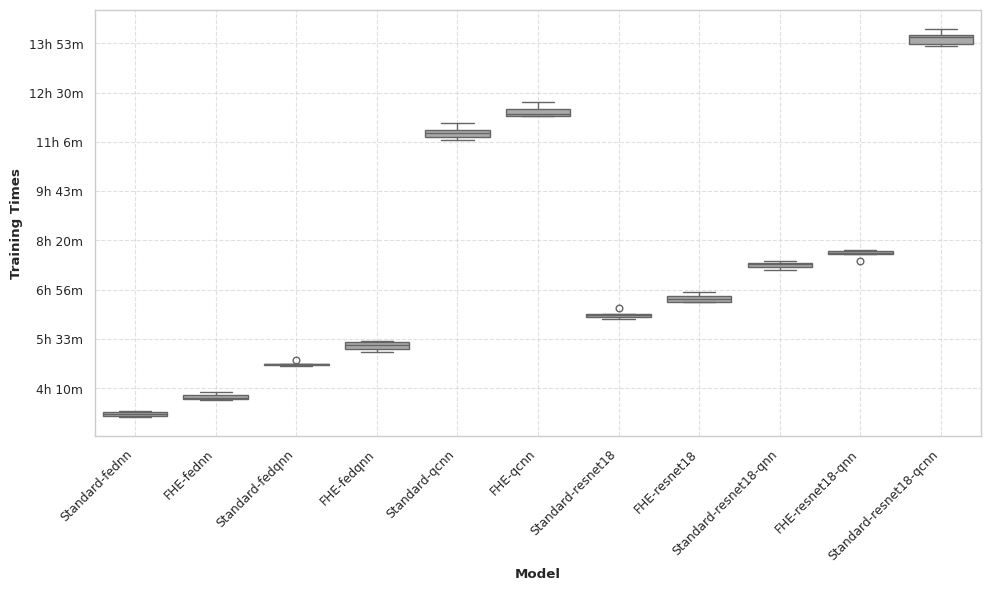

Model Training Times                                     \
                                    count        mean        std         min   
6           Standard-fednn       0.083333  206.397414   4.198245  201.791917   
0                FHE-fednn       0.083333  235.924622   5.473660  230.653374   
7          Standard-fedqnn       0.083333  291.824683   3.992422  288.200825   
1               FHE-fedqnn       0.083333  321.866503   7.601587  311.477119   
9        Standard-resnet18       0.083333  374.639014   6.709202  367.481466   
3             FHE-resnet18       0.083333  402.297008   7.237238  395.458787   
11   Standard-resnet18-qnn       0.083333  458.479619   5.980606  449.937233   
5         FHE-resnet18-qnn       0.083333  477.396852   6.979638  465.852546   
4        FHE-resnet18-qcnn       0.083333  477.865162  21.429522  463.219603   
8            Standard-qcnn       0.083333  682.231256  11.585660  669.136421   
2                 FHE-qcnn       0.083333  718.046793   9.871768  709.860702   
10  Standard-resnet18-qcnn       0.083333  842.036664  11.201412  829.752540   

                                                    
           25%         50%         75%         max  
6   202.861942  206.059314  210.033102  211.240794  
0   232.020477  234.180645  238.723706  244.044909  
7   290.014760  290.946286  291.330004  298.631538  
1   317.176311  322.951576  327.839327  329.888180  
9   370.470732  374.291951  375.827895  385.123029  
3   396.277331  401.146677  405.621841  412.980402  
11  455.142418  460.389549  461.788662  465.140230  
5   476.526360  479.203318  481.894498  483.507539  
4   464.729365  466.630637  480.602266  514.143941  
8   674.460103  682.090369  686.239302  699.230087  
2   711.043893  714.054688  721.560319  733.714363  
10  832.533730  843.752443  846.766217  857.378388

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


def format_time(seconds, _):
    if seconds < 60:
        return f"{int(seconds)}s"
    elif seconds < 3600:
        minutes = seconds // 60
        seconds = seconds % 60
        return f"{int(minutes)}m {int(seconds)}s"
    else:
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        return f"{int(hours)}h {int(minutes)}m"

def display_boxplot(metrics_df: pd.DataFrame, metric_label: str, formatter: FuncFormatter = None):
    sns.set_theme(style="whitegrid", context="paper")

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="Model", y=metric_label, data=metrics_df, color=COLOR)

    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Model", fontweight="bold")
    plt.ylabel(metric_label, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)


    if formatter:
        ax.yaxis.set_major_formatter(FuncFormatter(formatter))
    # Display the plot
    plt.tight_layout()
    plt.show()

metric_label = "Training Times"
df = get_dataframe_from_metrics_data(training_times, metric_label)
display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label, format_time)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

### Client Round Times

In [15]:
client_round_times = get_metric_by_model_type(runs, groups, "client_metric", "client_round_time")

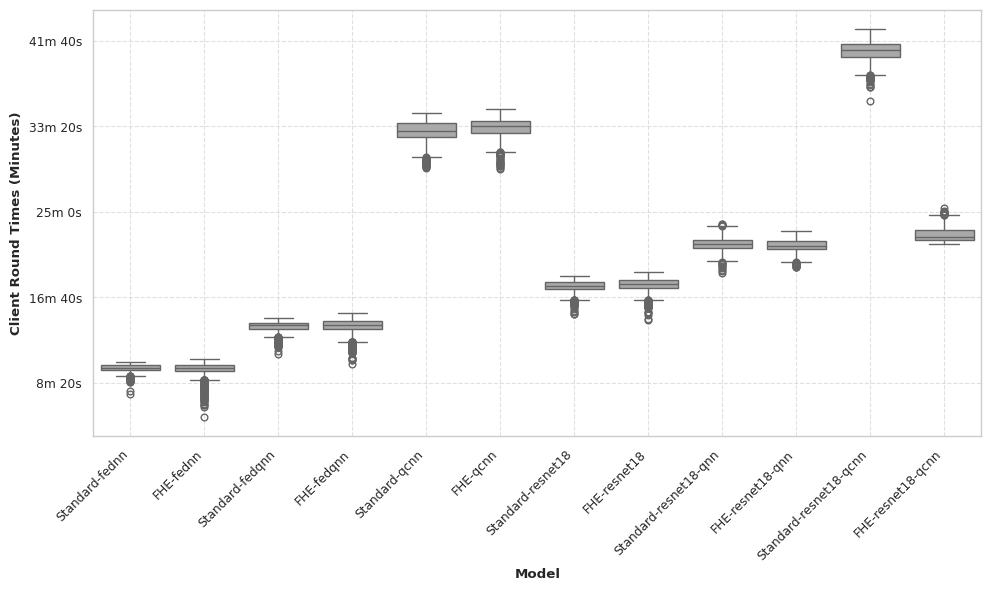

Model Client Round Times (Minutes)                       \
                                                  count       mean       std   
0                FHE-fednn                    33.333333   9.687771  0.625660   
6           Standard-fednn                    33.333333   9.818193  0.300696   
7          Standard-fedqnn                    33.333333  13.876930  0.465222   
1               FHE-fedqnn                    33.333333  13.891874  0.674002   
9        Standard-resnet18                    33.333333  17.762128  0.533725   
3             FHE-resnet18                    33.333333  17.904327  0.632366   
5         FHE-resnet18-qnn                    33.333333  21.712455  0.540821   
11   Standard-resnet18-qnn                    33.333333  21.868296  0.623483   
4        FHE-resnet18-qcnn                     1.666667  22.996932  0.962389   
8            Standard-qcnn                    33.333333  32.948752  0.987532   
2                 FHE-qcnn                    33.333333  33.264183  0.955408   
10  Standard-resnet18-qcnn                    33.333333  40.713777  0.856305   

                                                           
          min        25%        50%        75%        max  
0    5.038325   9.486892   9.799829  10.040007  10.661978  
6    7.220746   9.644195   9.816323  10.057921  10.349568  
7   11.132450  13.632824  13.964829  14.171611  14.655724  
1   10.174227  13.566307  13.991692  14.368373  15.189501  
9   15.013081  17.463502  17.807555  18.154918  18.712647  
3   14.441303  17.554642  17.976781  18.329076  19.178867  
5   19.616562  21.356522  21.713544  22.162002  23.140476  
11  19.090340  21.451291  21.866156  22.315043  23.813871  
4   21.910050  22.315756  22.587161  23.267289  25.353081  
8   29.304053  32.340653  32.880883  33.679745  34.667629  
2   29.143281  32.689858  33.360062  33.914125  35.079574  
10  35.769302  40.140669  40.819056  41.343736  42.815809

In [16]:
metric_label = "Client Round Times (Minutes)"
df = get_dataframe_from_metrics_data(client_round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

### Server Round Times

In [17]:
round_times = get_metric_by_model_type(runs, groups, "server_metric", "round_time")

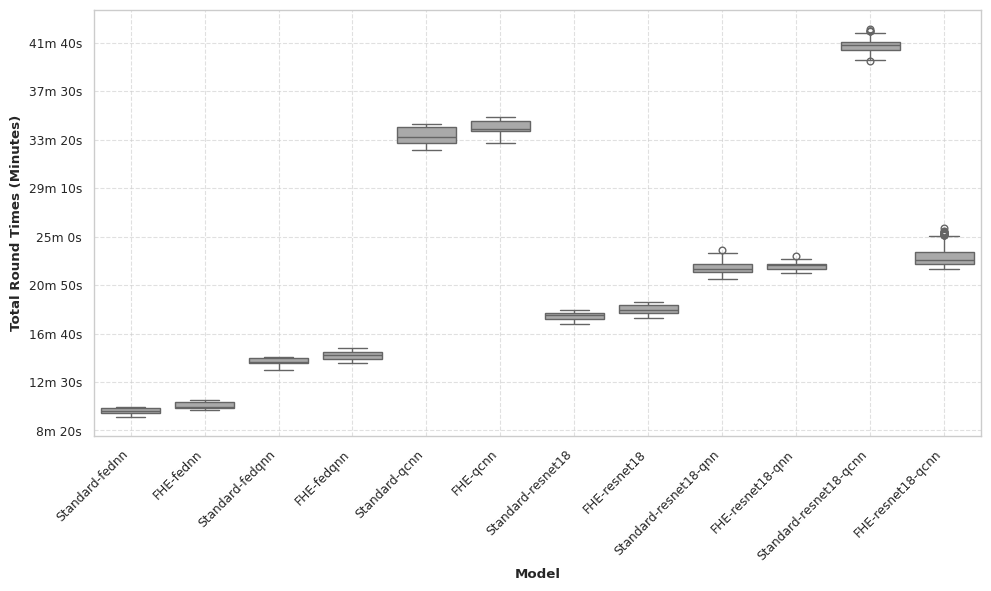

Model Total Round Times (Minutes)                       \
                                                 count       mean       std   
6           Standard-fednn                    1.666667  10.042793  0.227621   
0                FHE-fednn                    1.666667  10.464124  0.250768   
7          Standard-fedqnn                    1.666667  14.256723  0.268474   
1               FHE-fedqnn                    1.666667  14.725720  0.335946   
9        Standard-resnet18                    1.666667  18.162874  0.338306   
3             FHE-resnet18                    1.666667  18.731432  0.342975   
11   Standard-resnet18-qnn                    1.666667  22.307747  0.509249   
5         FHE-resnet18-qnn                    1.666667  22.488957  0.340155   
4        FHE-resnet18-qcnn                    1.666667  23.362951  0.972199   
8            Standard-qcnn                    1.666667  33.649009  0.763629   
2                 FHE-qcnn                    1.666667  34.386367  0.579580   
10  Standard-resnet18-qcnn                    1.666667  41.370287  0.637975   

                                                           
          min        25%        50%        75%        max  
6    9.507527   9.804808  10.017689  10.248815  10.357953  
0   10.122357  10.280817  10.359595  10.799868  10.950722  
7   13.490200  14.093551  14.202489  14.549571  14.666329  
1   14.158676  14.464546  14.801658  15.036865  15.383286  
9   17.482525  17.951248  18.220323  18.394247  18.720950  
3   17.962672  18.440515  18.677284  19.081555  19.379077  
11  21.336466  21.969167  22.212131  22.640861  23.842173  
5   21.884533  22.216422  22.582786  22.652284  23.338939  
4   22.243208  22.672487  22.949826  23.639610  25.733038  
8   32.456627  33.037717  33.559831  34.456550  34.675579  
2   33.033028  34.033413  34.208468  34.975974  35.276056  
10  40.100908  41.075732  41.482929  41.703531  42.828957

In [18]:
metric_label = "Total Round Times (Minutes)"
df = get_dataframe_from_metrics_data(round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

## CPU Usage

In [19]:
client_cpu_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_cpu_percentage")

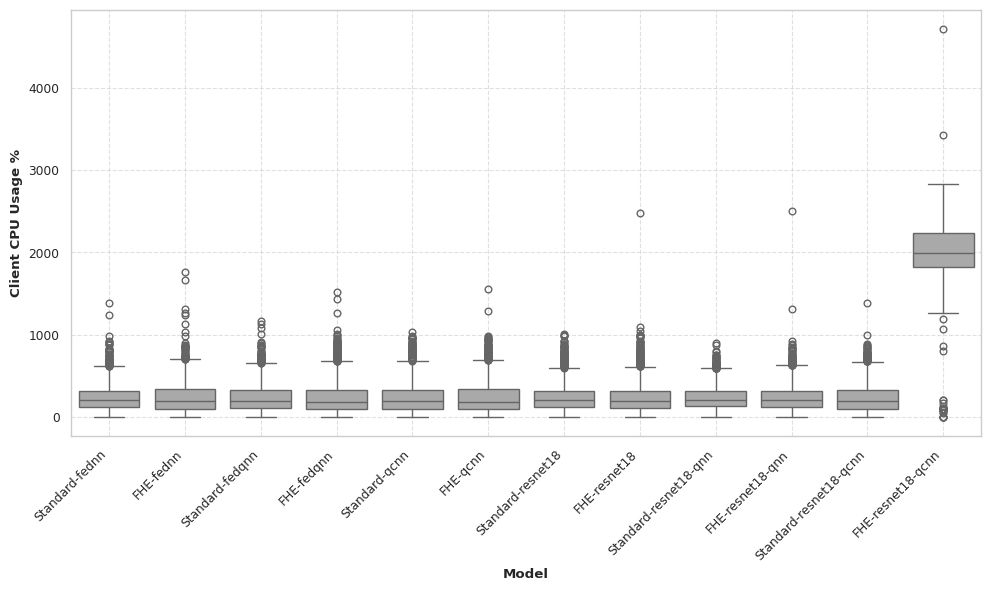

Client CPU Usage %                                \
                                    count         mean         std  min   
Model                                                                     
FHE-fednn                          2102.0   237.984110  185.001176  2.0   
FHE-fedqnn                         2228.0   237.797442  195.212953  2.0   
FHE-qcnn                           2372.0   238.946754  186.882039  2.0   
FHE-resnet18                       2321.0   232.701293  173.796874  2.0   
FHE-resnet18-qcnn                  2483.0  2000.466653  382.989266  2.0   
FHE-resnet18-qnn                   2364.0   237.403469  164.392871  1.8   
Standard-fednn                     2331.0   234.012827  152.016935  2.0   
Standard-fedqnn                    2317.0   234.035909  163.707980  2.0   
Standard-qcnn                      2433.0   237.461118  177.815429  2.0   
Standard-resnet18                  2301.0   239.519383  157.952657  2.0   
Standard-resnet18-qcnn             2454.0   237.769112  171.581770  2.0   
Standard-resnet18-qnn              2430.0   236.881235  139.517057  2.0   

                                                            
                             25%     50%       75%     max  
Model                                                       
FHE-fednn                 99.900   191.8   341.600  1763.8  
FHE-fedqnn                97.900   185.8   329.700  1518.5  
FHE-qcnn                  99.875   179.8   336.175  1556.5  
FHE-resnet18             105.900   195.8   309.600  2478.9  
FHE-resnet18-qcnn       1816.200  1988.1  2236.800  4710.7  
FHE-resnet18-qnn         115.900   201.8   320.100  2499.1  
Standard-fednn           119.900   201.8   317.700  1388.6  
Standard-fedqnn          103.900   195.8   323.700  1170.7  
Standard-qcnn             99.900   189.8   331.600  1028.5  
Standard-resnet18        123.900   207.8   313.700  1004.2  
Standard-resnet18-qcnn   101.900   197.8   331.700  1386.8  
Standard-resnet18-qnn    130.350   207.8   315.325   897.1

In [20]:
metric_label = "Client CPU Usage %"
df = get_dataframe_from_metrics_data(client_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)
df.groupby("Model").describe()

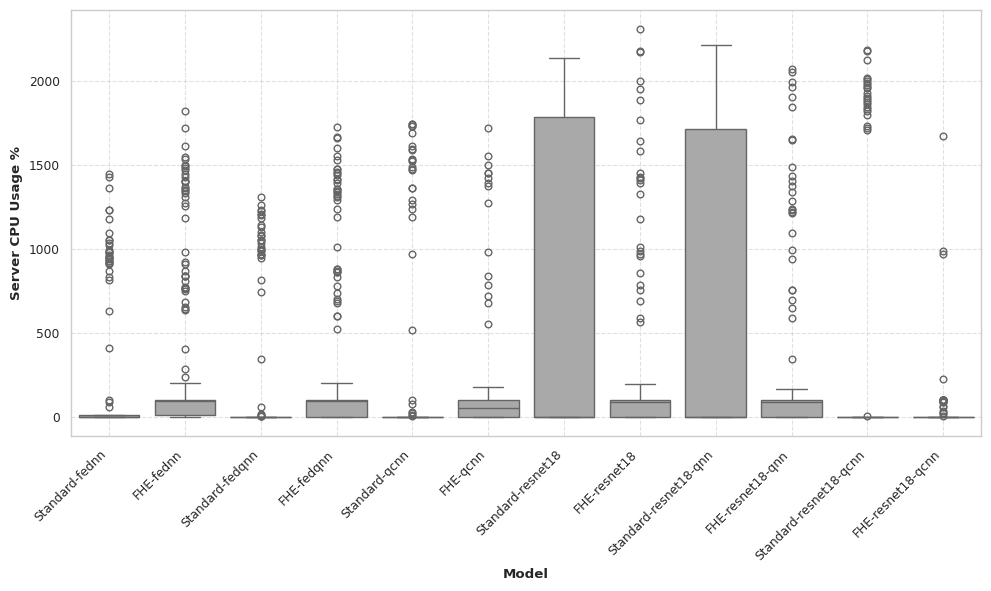

Server CPU Usage %                                     \
                                    count        mean         std  min   25%   
Model                                                                          
FHE-fednn                           450.0  166.269333  331.891950  2.0  14.0   
FHE-fedqnn                          396.0  172.210606  353.122735  2.0   2.0   
FHE-qcnn                            215.0  127.774419  308.802546  2.0   2.0   
FHE-resnet18                        322.0  163.661491  386.374819  1.9   2.0   
FHE-resnet18-qcnn                   162.0   37.134568  171.179081  2.0   2.0   
FHE-resnet18-qnn                    296.0  172.188851  389.945045  2.0   2.0   
Standard-fednn                      133.0  229.363158  429.584277  2.0   2.0   
Standard-fedqnn                     132.0  207.543939  423.379602  2.0   2.0   
Standard-qcnn                       137.0  234.778832  541.754303  2.0   2.0   
Standard-resnet18                   134.0  596.367164  881.354440  2.0   2.0   
Standard-resnet18-qcnn              108.0  411.442593  792.880388  2.0   2.0   
Standard-resnet18-qnn               146.0  597.878767  855.302432  2.0   2.0   

                                                
                         50%       75%     max  
Model                                           
FHE-fednn               97.9    99.900  1824.1  
FHE-fedqnn              97.9    99.900  1725.7  
FHE-qcnn                53.9    99.900  1721.9  
FHE-resnet18            91.9    99.900  2310.1  
FHE-resnet18-qcnn        2.0     2.000  1672.4  
FHE-resnet18-qnn        89.9    99.900  2071.7  
Standard-fednn           2.0    12.000  1448.7  
Standard-fedqnn          2.0     2.500  1308.7  
Standard-qcnn            2.0     2.000  1746.5  
Standard-resnet18        2.0  1785.325  2135.8  
Standard-resnet18-qcnn   2.0     2.000  2186.0  
Standard-resnet18-qnn    2.0  1712.850  2218.1

In [21]:
server_cpu_usage = get_metric_by_model_type(runs, groups, "system_metric", "server_cpu_percentage")
metric_label = "Server CPU Usage %"
df = get_dataframe_from_metrics_data(server_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)
df.groupby("Model").describe()

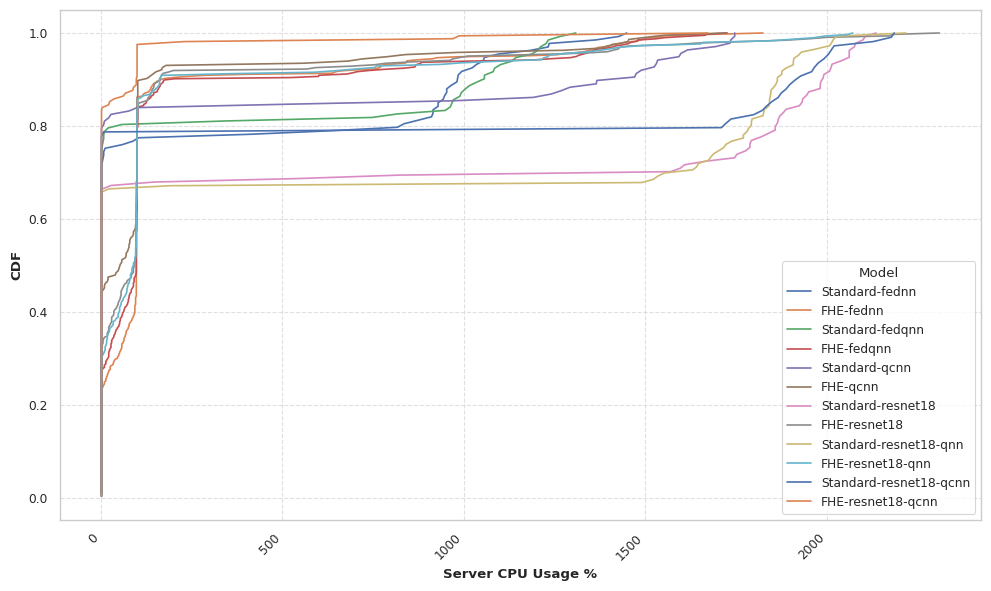

In [22]:
def display_cdf_plot(metrics_df: pd.DataFrame, metric_label: str):
    sns.set_theme(style="whitegrid", context="paper")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for model in metrics_df['Model'].unique():
        data = metrics_df[metrics_df['Model'] == model][metric_label]
        # Sort data for CDF calculation
        data_sorted = np.sort(data)
        cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        ax.plot(data_sorted, cdf, label=model)
    
    plt.xticks(rotation=45, ha="right")
    plt.xlabel(metric_label, fontweight="bold")
    plt.ylabel("CDF", fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)
    
    ax.legend(title='Model')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
display_cdf_plot(df, metric_label)

# RAM Usage

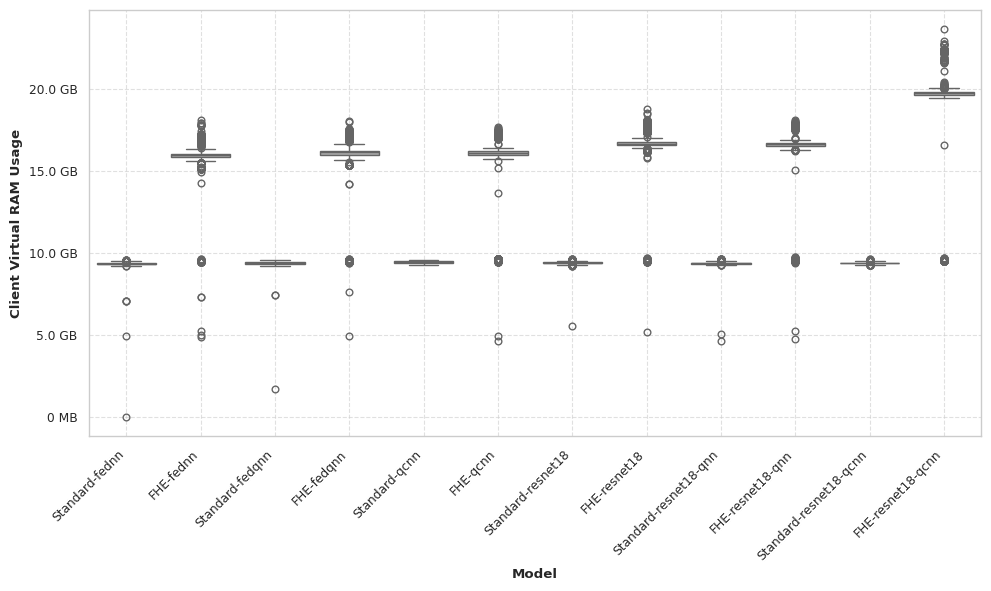

Client Virtual RAM Usage                             \
                                          count          mean          std   
Model                                                                        
FHE-fednn                                2439.0  15782.362763  1404.857066   
FHE-fedqnn                               2477.0  15871.604915  1518.820522   
FHE-qcnn                                 2498.0  15863.129350  1424.140489   
FHE-resnet18                             2493.0  16434.029215  1508.211982   
FHE-resnet18-qcnn                        2499.0  19418.816304  2003.577200   
FHE-resnet18-qnn                         2494.0  16384.053290  1463.496082   
Standard-fednn                           2456.0   9349.221611   229.974670   
Standard-fedqnn                          2491.0   9372.566946   173.937933   
Standard-qcnn                            2483.0   9431.907128    60.995894   
Standard-resnet18                        2498.0   9392.647416    93.685745   
Standard-resnet18-qcnn                   2498.0   9394.303451    43.539576   
Standard-resnet18-qnn                    2495.0   9390.048143   138.571578   

                                                                        \
                             min          25%         50%          75%   
Model                                                                    
FHE-fednn               4910.238  15828.12300  15941.1370  16039.63300   
FHE-fedqnn              4913.426  15981.25800  16126.0430  16236.77700   
FHE-qcnn                4639.023  15996.31600  16109.9490  16191.17600   
FHE-resnet18            5160.953  16586.74200  16655.3400  16755.91800   
FHE-resnet18-qcnn       9498.305  19621.50400  19756.1020  19803.41400   
FHE-resnet18-qnn        4779.199  16538.36300  16613.4690  16703.69100   
Standard-fednn            18.547   9317.66400   9347.7325   9383.40200   
Standard-fedqnn         1723.215   9327.80500   9370.1330   9429.87500   
Standard-qcnn           9257.957   9381.97650   9450.2030   9480.26750   
Standard-resnet18       5549.355   9360.17375   9391.6720   9420.76625   
Standard-resnet18-qcnn  9255.590   9367.38700   9393.3440   9414.73800   
Standard-resnet18-qnn   4650.043   9357.65250   9389.4770   9416.32600   

                                   
                              max  
Model                              
FHE-fednn               18075.988  
FHE-fedqnn              18022.059  
FHE-qcnn                17647.379  
FHE-resnet18            18760.969  
FHE-resnet18-qcnn       23632.793  
FHE-resnet18-qnn        18098.176  
Standard-fednn           9568.348  
Standard-fedqnn          9555.586  
Standard-qcnn            9580.500  
Standard-resnet18        9623.297  
Standard-resnet18-qcnn   9624.750  
Standard-resnet18-qnn    9633.387

In [23]:
def format_usage(usage_mb, _):
    if usage_mb < 1_000:
        return f"{int(usage_mb)} MB"
    else:
        gb = round(usage_mb / 1_000, 2)
        return f"{gb} GB"
    
client_vir_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_virtual_memory_mb")
metric_label = "Client Virtual RAM Usage"
df = get_dataframe_from_metrics_data(client_vir_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

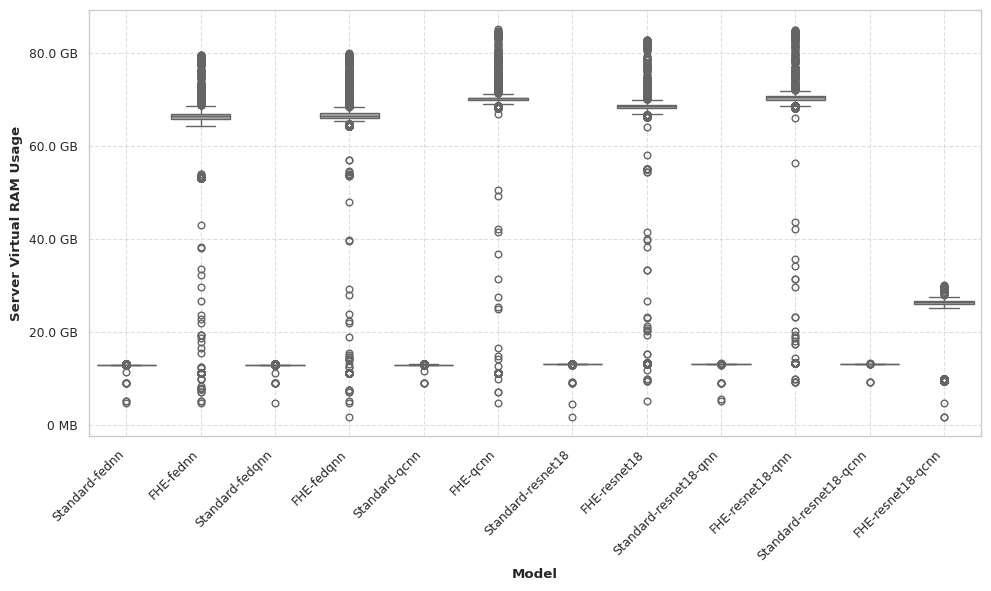

Server Virtual RAM Usage                              \
                                          count          mean           std   
Model                                                                         
FHE-fednn                                2436.0  64513.627312  12790.588348   
FHE-fedqnn                               2467.0  64528.063294  12879.275847   
FHE-qcnn                                 2500.0  68011.562520  12750.896493   
FHE-resnet18                             2494.0  66611.273823  12251.967737   
FHE-resnet18-qcnn                        2500.0  25633.315658   3782.884492   
FHE-resnet18-qnn                         2500.0  67916.766632  13318.460664   
Standard-fednn                           2431.0  12917.346670    342.167846   
Standard-fedqnn                          2420.0  12937.055817    274.631728   
Standard-qcnn                            2500.0  12943.994138    162.750683   
Standard-resnet18                        2414.0  13026.770725    339.585210   
Standard-resnet18-qcnn                   2500.0  13058.017906    136.737138   
Standard-resnet18-qnn                    2500.0  13040.644619    293.574863   

                                                                              
                             min        25%        50%        75%        max  
Model                                                                         
FHE-fednn               4822.840  65658.719  66372.645  66846.566  79543.648  
FHE-fedqnn              1762.414  66054.570  66329.539  66964.250  79842.934  
FHE-qcnn                4820.797  69718.164  70203.121  70311.332  85029.195  
FHE-resnet18            5088.578  67992.770  68471.895  68761.164  82795.918  
FHE-resnet18-qcnn       1756.480  25974.812  26423.293  26677.832  30135.578  
FHE-resnet18-qnn        9257.020  69813.551  70396.336  70653.574  84944.426  
Standard-fednn          4723.410  12919.430  12932.387  12954.457  13034.020  
Standard-fedqnn         4629.316  12951.418  12956.043  12957.957  13066.484  
Standard-qcnn           8982.984  12940.961  12953.758  12962.957  13025.180  
Standard-resnet18       1750.848  13026.207  13050.688  13055.039  13200.688  
Standard-resnet18-qcnn  9147.719  13047.598  13062.035  13077.113  13268.363  
Standard-resnet18-qnn   5106.922  13049.434  13060.910  13063.293  13212.109

In [24]:
server_vir_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "server_virtual_memory_mb")
metric_label = "Server Virtual RAM Usage"
df = get_dataframe_from_metrics_data(server_vir_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

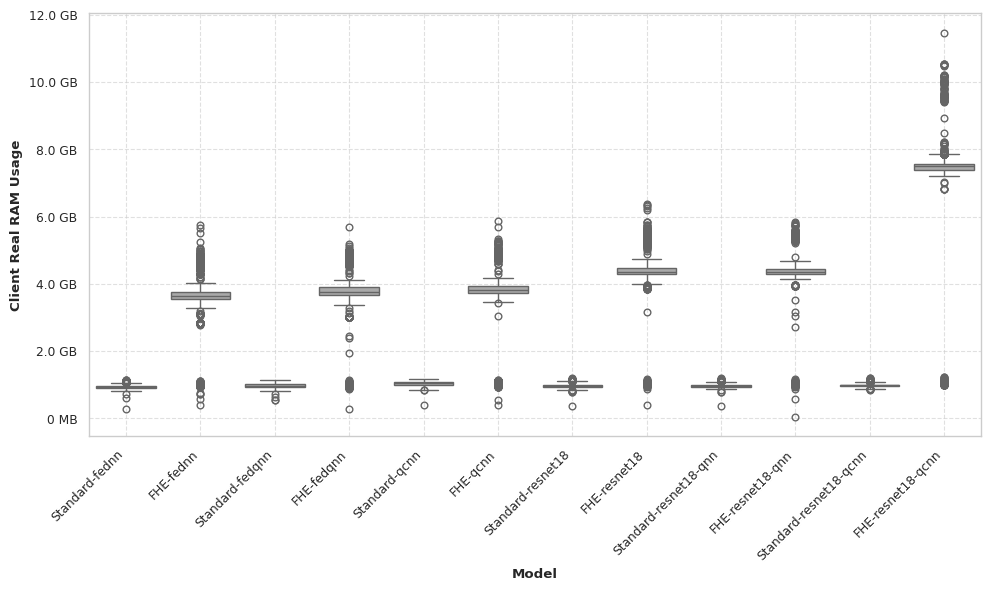

Client Real RAM Usage                            \
                                       count         mean          std   
Model                                                                    
FHE-fednn                             2443.0  3659.661768   666.406969   
FHE-fedqnn                            2474.0  3740.687629   658.457320   
FHE-qcnn                              2498.0  3744.541879   702.311312   
FHE-resnet18                          2490.0  4301.199522   786.524030   
FHE-resnet18-qcnn                     2499.0  7284.056189  1444.491824   
FHE-resnet18-qnn                      2497.0  4283.289850   760.207590   
Standard-fednn                        2436.0   948.749368    55.652782   
Standard-fedqnn                       2482.0   974.918660    62.586002   
Standard-qcnn                         2482.0  1033.423001    61.909365   
Standard-resnet18                     2496.0   975.380927    54.686390   
Standard-resnet18-qcnn                2498.0   986.875391    42.368806   
Standard-resnet18-qnn                 2498.0   977.653800    51.841703   

                                                                               
                            min         25%        50%         75%        max  
Model                                                                          
FHE-fednn               387.750  3547.21050  3651.3950  3771.76200   5738.895  
FHE-fedqnn              270.375  3664.99000  3772.7675  3893.87325   5683.648  
FHE-qcnn                400.848  3738.39175  3828.8440  3929.19950   5868.812  
FHE-resnet18            384.684  4279.87900  4352.1700  4470.58750   6375.535  
FHE-resnet18-qcnn       999.414  7383.74200  7491.8090  7568.91800  11464.660  
FHE-resnet18-qnn         43.504  4289.73000  4352.0700  4451.34000   5836.289  
Standard-fednn          293.812   912.24200   937.7165   974.03150   1141.617  
Standard-fedqnn         541.297   926.97075   970.3925  1023.00100   1143.727  
Standard-qcnn           388.398   985.47200  1051.8240  1083.07250   1164.934  
Standard-resnet18       374.215   937.99450   970.4590  1007.28700   1188.977  
Standard-resnet18-qcnn  850.707   959.60750   985.1760  1008.65225   1195.023  
Standard-resnet18-qnn   357.840   944.25200   974.3360  1005.14725   1210.215

In [25]:
client_real_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_real_memory_mb")
metric_label = "Client Real RAM Usage"
df = get_dataframe_from_metrics_data(client_real_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

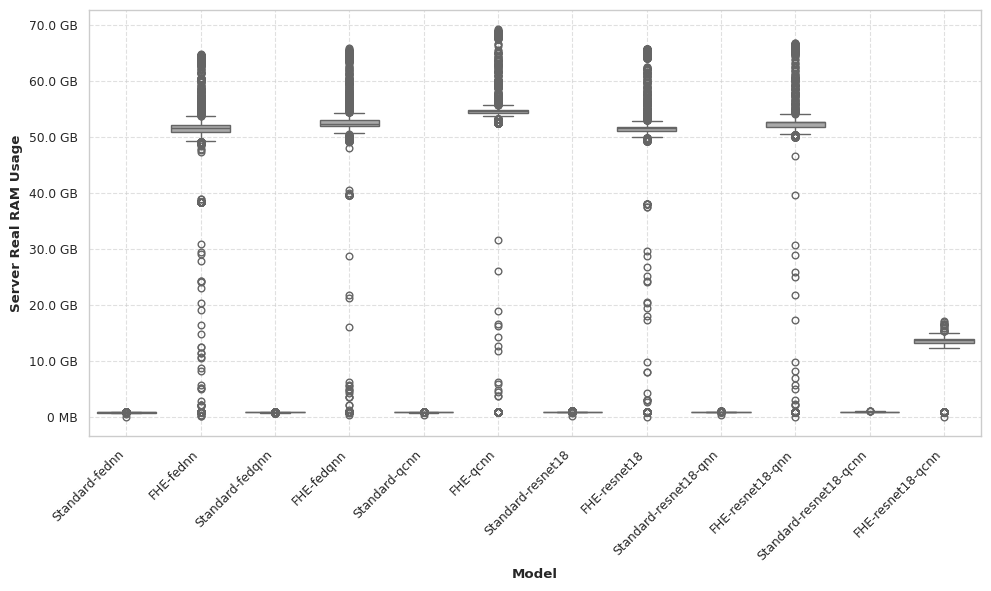

Server Real RAM Usage                              \
                                       count          mean           std   
Model                                                                      
FHE-fednn                             2456.0  49475.331805  12489.312038   
FHE-fedqnn                            2466.0  50451.982958  12503.612535   
FHE-qcnn                              2500.0  52868.994026  11450.864206   
FHE-resnet18                          2486.0  49931.354888  11225.540012   
FHE-resnet18-qcnn                     2500.0  13103.739872   2843.162892   
FHE-resnet18-qnn                      2500.0  50513.738931  11945.487839   
Standard-fednn                        2450.0    805.679700     26.075668   
Standard-fedqnn                       2425.0    824.826689     21.614304   
Standard-qcnn                         2500.0    824.860007     23.918849   
Standard-resnet18                     2401.0    905.866782     34.158841   
Standard-resnet18-qcnn                2500.0    927.583593     18.910105   
Standard-resnet18-qnn                 2500.0    920.234786     20.493947   

                                                                             
                            min        25%        50%        75%        max  
Model                                                                        
FHE-fednn                98.000  50929.152  51616.375  52075.930  64807.363  
FHE-fedqnn              417.219  52006.168  52338.391  52961.492  65839.988  
FHE-qcnn                880.703  54229.312  54714.605  54804.199  69261.906  
FHE-resnet18             70.500  51027.422  51634.738  51795.125  65652.453  
FHE-resnet18-qcnn        73.500  13240.848  13687.262  13960.633  17156.012  
FHE-resnet18-qnn         75.238  51809.535  52621.203  52744.941  66837.703  
Standard-fednn           21.000    788.316    800.215    820.340    908.684  
Standard-fedqnn         779.098    815.133    827.762    833.555    947.172  
Standard-qcnn           406.750    814.691    826.000    837.684    899.305  
Standard-resnet18       150.500    892.188    910.766    917.828   1041.961  
Standard-resnet18-qcnn  881.219    912.129    930.039    943.145   1115.910  
Standard-resnet18-qnn   359.191    910.234    923.934    931.367   1098.496

In [26]:
server_real_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "server_real_memory_mb")
metric_label = "Server Real RAM Usage"
df = get_dataframe_from_metrics_data(server_real_ram_usage, metric_label)
display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

# FHE

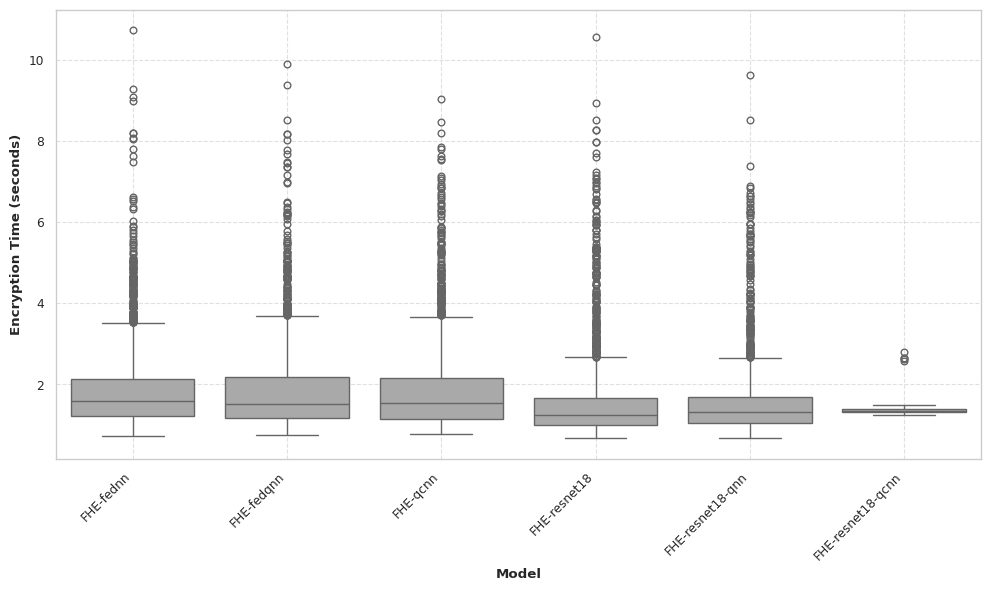

Encryption Time (seconds)                                \
                                      count      mean       std       min   
Model                                                                       
FHE-fednn                            2000.0  1.873207  1.053132  0.716592   
FHE-fedqnn                           2000.0  1.863797  1.087581  0.750992   
FHE-qcnn                             2000.0  1.874507  1.112628  0.775469   
FHE-resnet18                         2000.0  1.590038  1.116067  0.672745   
FHE-resnet18-qcnn                     100.0  1.408063  0.294673  1.246953   
FHE-resnet18-qnn                     2000.0  1.554495  0.940024  0.687920   

                                                            
                        25%       50%       75%        max  
Model                                                       
FHE-fednn          1.213804  1.593228  2.142175  10.733194  
FHE-fedqnn         1.169908  1.523361  2.178773   9.906615  
FHE-qcnn           1.144771  1.531817  2.158925   9.029217  
FHE-resnet18       0.987157  1.256004  1.658655  10.557287  
FHE-resnet18-qcnn  1.307043  1.337699  1.381020   2.803933  
FHE-resnet18-qnn   1.039481  1.309266  1.687874   9.634766

In [27]:
client_encryption_time = get_metric_by_model_type(runs, groups, "client_metric", "encryption_time")
metric_label = "Encryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_encryption_time, metric_label)

display_boxplot(df, metric_label)
df.groupby("Model").describe()

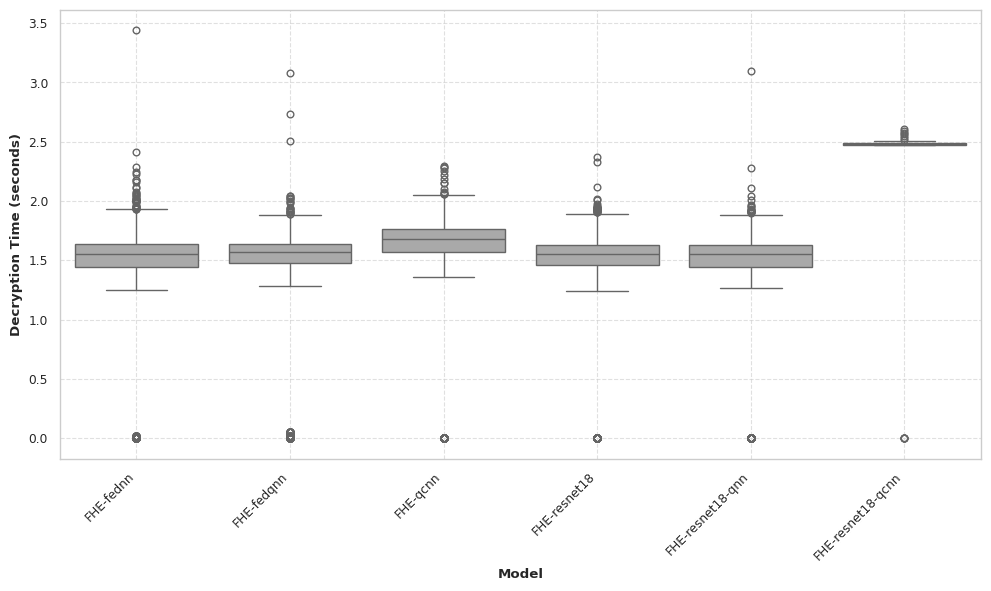

Decryption Time (seconds)                                \
                                      count      mean       std       min   
Model                                                                       
FHE-fednn                            2100.0  1.486596  0.363628  0.000890   
FHE-fedqnn                           2100.0  1.497471  0.355059  0.000835   
FHE-qcnn                             2100.0  1.599588  0.382238  0.000800   
FHE-resnet18                         2100.0  1.479867  0.357188  0.000391   
FHE-resnet18-qcnn                     105.0  2.371106  0.533085  0.000653   
FHE-resnet18-qnn                     2100.0  1.478662  0.354918  0.000431   

                                                           
                        25%       50%       75%       max  
Model                                                      
FHE-fednn          1.442930  1.552312  1.638529  3.439762  
FHE-fedqnn         1.477717  1.568562  1.640781  3.074909  
FHE-qcnn           1.566594  1.680281  1.763249  2.298754  
FHE-resnet18       1.456230  1.551103  1.632708  2.367349  
FHE-resnet18-qcnn  2.475924  2.482024  2.492004  2.606292  
FHE-resnet18-qnn   1.447173  1.556417  1.627599  3.094998

In [39]:
client_decryption_time = get_metric_by_model_type(runs, groups, "client_metric", "decryption_time")
metric_label = "Decryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_decryption_time, metric_label)

display_boxplot(df, metric_label)
df.groupby("Model").describe()

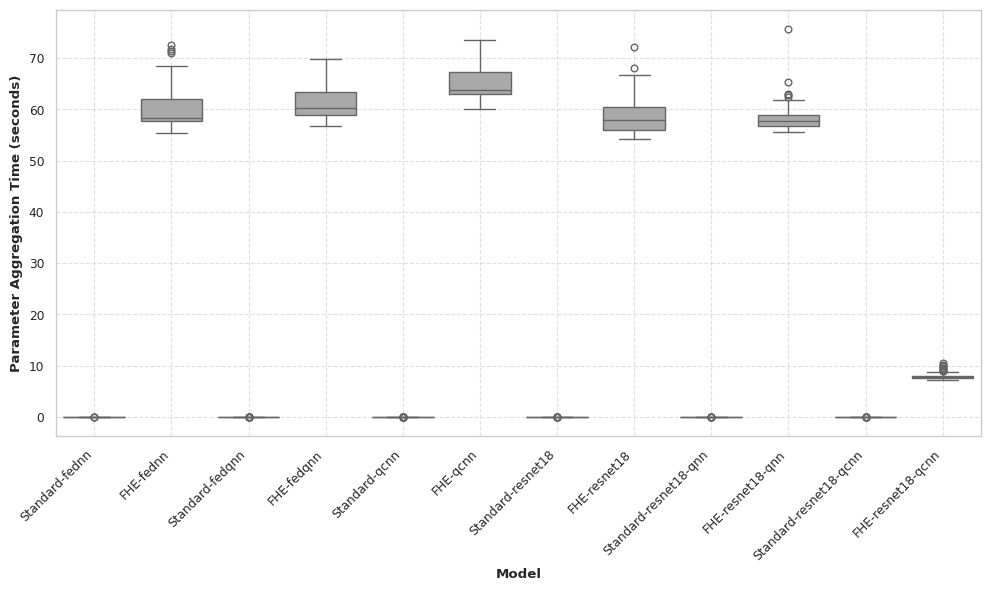

Parameter Aggregation Time (seconds)             \
                                                      count       mean   
Model                                                                    
FHE-fednn                                             100.0  59.790676   
FHE-fedqnn                                            100.0  61.168137   
FHE-qcnn                                              100.0  64.833991   
FHE-resnet18                                          100.0  58.707018   
FHE-resnet18-qcnn                                     100.0   7.907789   
FHE-resnet18-qnn                                      100.0  58.268315   
Standard-fednn                                        100.0   0.025263   
Standard-fedqnn                                       100.0   0.034403   
Standard-qcnn                                         100.0   0.034711   
Standard-resnet18                                     100.0   0.006675   
Standard-resnet18-qcnn                                100.0   0.015985   
Standard-resnet18-qnn                                 100.0   0.015896   

                                                                              \
                             std        min        25%        50%        75%   
Model                                                                          
FHE-fednn               3.686657  55.427822  57.701411  58.356875  62.078650   
FHE-fedqnn              3.005746  56.826933  58.980760  60.186729  63.426057   
FHE-qcnn                3.025415  60.053301  63.027990  63.736184  67.362918   
FHE-resnet18            3.595246  54.226566  55.933147  57.970505  60.534344   
FHE-resnet18-qcnn       0.636266   7.281575   7.537316   7.753109   8.004150   
FHE-resnet18-qnn        2.538673  55.592551  56.713159  57.686546  58.946140   
Standard-fednn          0.000693   0.024445   0.024848   0.025023   0.025514   
Standard-fedqnn         0.001151   0.033249   0.033799   0.034076   0.034582   
Standard-qcnn           0.001183   0.033573   0.034013   0.034377   0.034813   
Standard-resnet18       0.000187   0.006416   0.006583   0.006627   0.006706   
Standard-resnet18-qcnn  0.000219   0.015685   0.015853   0.015935   0.016027   
Standard-resnet18-qnn   0.000311   0.015483   0.015688   0.015823   0.016001   

                                   
                              max  
Model                              
FHE-fednn               72.595167  
FHE-fedqnn              69.732001  
FHE-qcnn                73.447276  
FHE-resnet18            72.099207  
FHE-resnet18-qcnn       10.574440  
FHE-resnet18-qnn        75.647678  
Standard-fednn           0.028986  
Standard-fedqnn          0.042843  
Standard-qcnn            0.040678  
Standard-resnet18        0.007984  
Standard-resnet18-qcnn   0.016755  
Standard-resnet18-qnn    0.017221

In [29]:
server_aggregation_time = get_metric_by_model_type(runs, groups, "server_metric", "parameter_aggregation_time")
metric_label = "Parameter Aggregation Time (seconds)"
df = get_dataframe_from_metrics_data(server_aggregation_time, metric_label)

display_boxplot(df, metric_label)
df.groupby("Model").describe()

# Communication Overhead

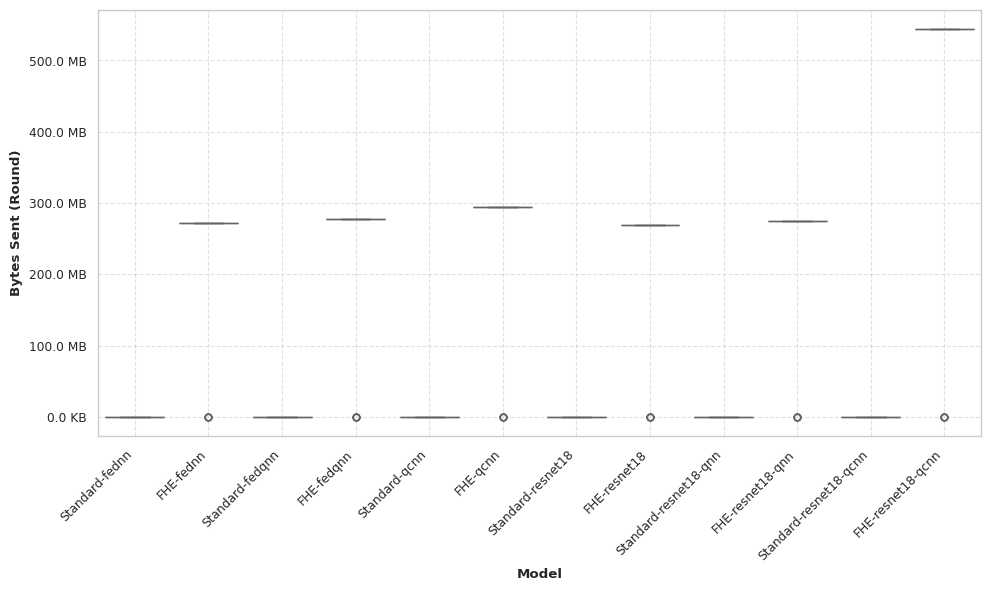

Bytes Sent (Round)                              \
                                    count          mean           std   
Model                                                                   
FHE-fednn                           100.0  2.577641e+08  5.943088e+07   
FHE-fedqnn                          100.0  2.632485e+08  6.069529e+07   
FHE-qcnn                            100.0  2.793276e+08  6.440255e+07   
FHE-resnet18                        100.0  2.557696e+08  5.897121e+07   
FHE-resnet18-qcnn                   100.0  5.166496e+08  1.191207e+08   
FHE-resnet18-qnn                    100.0  2.612541e+08  6.023563e+07   
Standard-fednn                      100.0  9.435000e+03  0.000000e+00   
Standard-fedqnn                     100.0  1.000400e+04  0.000000e+00   
Standard-qcnn                       100.0  1.052000e+04  0.000000e+00   
Standard-resnet18                   100.0  8.573000e+03  0.000000e+00   
Standard-resnet18-qcnn              100.0  1.733800e+04  0.000000e+00   
Standard-resnet18-qnn               100.0  9.142000e+03  0.000000e+00   

                                                                        \
                            min          25%          50%          75%   
Model                                                                    
FHE-fednn                9435.0  271330133.0  271330133.0  271330133.0   
FHE-fedqnn              10004.0  277103165.0  277103165.0  277103165.0   
FHE-qcnn                10520.0  294028480.0  294028480.0  294028480.0   
FHE-resnet18             8573.0  269230755.0  269230755.0  269230755.0   
FHE-resnet18-qcnn       17338.0  543840782.0  543840782.0  543840782.0   
FHE-resnet18-qnn         9142.0  275003787.0  275003787.0  275003787.0   
Standard-fednn           9435.0       9435.0       9435.0       9435.0   
Standard-fedqnn         10004.0      10004.0      10004.0      10004.0   
Standard-qcnn           10520.0      10520.0      10520.0      10520.0   
Standard-resnet18        8573.0       8573.0       8573.0       8573.0   
Standard-resnet18-qcnn  17338.0      17338.0      17338.0      17338.0   
Standard-resnet18-qnn    9142.0       9142.0       9142.0       9142.0   

                                     
                                max  
Model                                
FHE-fednn               271330133.0  
FHE-fedqnn              277103165.0  
FHE-qcnn                294028480.0  
FHE-resnet18            269230755.0  
FHE-resnet18-qcnn       543840782.0  
FHE-resnet18-qnn        275003787.0  
Standard-fednn               9435.0  
Standard-fedqnn             10004.0  
Standard-qcnn               10520.0  
Standard-resnet18            8573.0  
Standard-resnet18-qcnn      17338.0  
Standard-resnet18-qnn        9142.0

In [30]:
def format_bytes(bytes, _):
    if bytes < 1_000_000:
        value = round(int(bytes) * 0.001, 2)
        return f"{value} KB"
    if bytes < 1_000_000_000:
        value = round(int(bytes) * 0.000001, 2)
        return f"{value} MB"
    else:
        value = round(int(bytes) * 1e-9, 2)
        return f"{value} GB"
    
server_bytes_sent = get_metric_by_model_type(runs, groups, "server_metric", "Bytes Sent (Round)")
metric_label = "Bytes Sent (Round)"
df = get_dataframe_from_metrics_data(server_bytes_sent, metric_label)

display_boxplot(df, metric_label, format_bytes)
df.groupby("Model").describe()

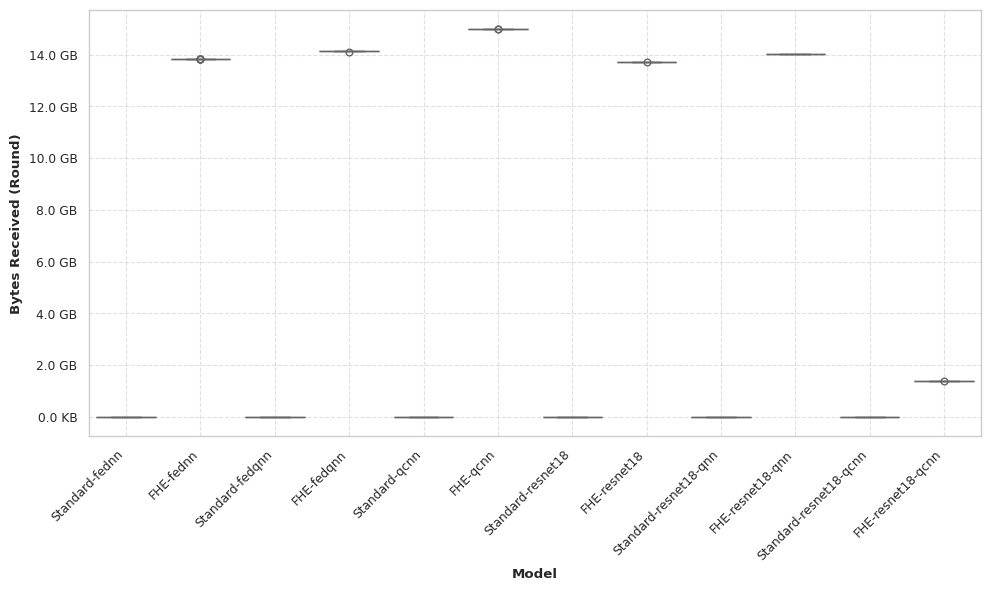

Bytes Received (Round)                              \
                                        count          mean           std   
Model                                                                       
FHE-fednn                               100.0  1.382569e+10  36938.063433   
FHE-fedqnn                              100.0  1.411986e+10  38749.213359   
FHE-qcnn                                100.0  1.498229e+10  44029.084480   
FHE-resnet18                            100.0  1.371872e+10  42268.551286   
FHE-resnet18-qcnn                       100.0  1.385579e+09  11847.282711   
FHE-resnet18-qnn                        100.0  1.401289e+10  39523.675248   
Standard-fednn                          100.0  1.887000e+05      0.000000   
Standard-fedqnn                         100.0  2.000800e+05      0.000000   
Standard-qcnn                           100.0  2.104000e+05      0.000000   
Standard-resnet18                       100.0  1.714600e+05      0.000000   
Standard-resnet18-qcnn                  100.0  3.467600e+05      0.000000   
Standard-resnet18-qnn                   100.0  1.828400e+05      0.000000   

                                                                  \
                                 min           25%           50%   
Model                                                              
FHE-fednn               1.382558e+10  1.382567e+10  1.382569e+10   
FHE-fedqnn              1.411972e+10  1.411984e+10  1.411986e+10   
FHE-qcnn                1.498215e+10  1.498226e+10  1.498229e+10   
FHE-resnet18            1.371864e+10  1.371869e+10  1.371872e+10   
FHE-resnet18-qcnn       1.385549e+09  1.385570e+09  1.385578e+09   
FHE-resnet18-qnn        1.401281e+10  1.401285e+10  1.401289e+10   
Standard-fednn          1.887000e+05  1.887000e+05  1.887000e+05   
Standard-fedqnn         2.000800e+05  2.000800e+05  2.000800e+05   
Standard-qcnn           2.104000e+05  2.104000e+05  2.104000e+05   
Standard-resnet18       1.714600e+05  1.714600e+05  1.714600e+05   
Standard-resnet18-qcnn  3.467600e+05  3.467600e+05  3.467600e+05   
Standard-resnet18-qnn   1.828400e+05  1.828400e+05  1.828400e+05   

                                                    
                                 75%           max  
Model                                               
FHE-fednn               1.382571e+10  1.382578e+10  
FHE-fedqnn              1.411989e+10  1.411995e+10  
FHE-qcnn                1.498232e+10  1.498238e+10  
FHE-resnet18            1.371875e+10  1.371885e+10  
FHE-resnet18-qcnn       1.385586e+09  1.385613e+09  
FHE-resnet18-qnn        1.401292e+10  1.401299e+10  
Standard-fednn          1.887000e+05  1.887000e+05  
Standard-fedqnn         2.000800e+05  2.000800e+05  
Standard-qcnn           2.104000e+05  2.104000e+05  
Standard-resnet18       1.714600e+05  1.714600e+05  
Standard-resnet18-qcnn  3.467600e+05  3.467600e+05  
Standard-resnet18-qnn   1.828400e+05  1.828400e+05

In [31]:
server_bytes_received = get_metric_by_model_type(runs, groups, "server_metric", "Bytes Received (Round)")
metric_label = "Bytes Received (Round)"
df = get_dataframe_from_metrics_data(server_bytes_received, metric_label)

display_boxplot(df, metric_label, format_bytes)
df.groupby("Model").describe()

In [32]:
server_total_bytes_sent = get_metric_by_model_type(runs, groups, "server_metric", "Total Bytes Sent")
metric_label = "Total Bytes Sent"
df = get_dataframe_from_metrics_data(server_total_bytes_sent, metric_label)

for model in KEY_ORDER:
    print(f"{model}: {format_bytes(max(df[df["Model"] == model]["Total Bytes Sent"]), _)}")

df.groupby("Model").describe()

Standard-fednn: 188.7 KB
FHE-fednn: 5.16 GB
Standard-fedqnn: 200.08 KB
FHE-fedqnn: 5.26 GB
Standard-qcnn: 210.4 KB
FHE-qcnn: 5.59 GB
Standard-resnet18: 171.46 KB
FHE-resnet18: 5.12 GB
Standard-resnet18-qnn: 182.84 KB
FHE-resnet18-qnn: 5.23 GB
Standard-resnet18-qcnn: 346.76 KB
FHE-resnet18-qcnn: 10.33 GB


Total Bytes Sent                                       \
                                  count          mean           std      min   
Model                                                                          
FHE-fednn                         100.0  2.577646e+09  1.572448e+09   9435.0   
FHE-fedqnn                        100.0  2.632490e+09  1.605904e+09  10004.0   
FHE-qcnn                          100.0  2.793281e+09  1.703992e+09  10520.0   
FHE-resnet18                      100.0  2.557701e+09  1.560281e+09   8573.0   
FHE-resnet18-qcnn                 100.0  5.166505e+09  3.151737e+09  17338.0   
FHE-resnet18-qnn                  100.0  2.612545e+09  1.593738e+09   9142.0   
Standard-fednn                    100.0  9.906750e+04  5.467895e+04   9435.0   
Standard-fedqnn                   100.0  1.050420e+05  5.797649e+04  10004.0   
Standard-qcnn                     100.0  1.104600e+05  6.096688e+04  10520.0   
Standard-resnet18                 100.0  9.001650e+04  4.968337e+04   8573.0   
Standard-resnet18-qcnn            100.0  1.820490e+05  1.004794e+05  17338.0   
Standard-resnet18-qnn             100.0  9.599100e+04  5.298091e+04   9142.0   

                                                                                
                                 25%           50%           75%           max  
Model                                                                           
FHE-fednn               1.288828e+09  2.577646e+09  3.866464e+09  5.155282e+09  
FHE-fedqnn              1.316250e+09  2.632490e+09  3.948730e+09  5.264970e+09  
FHE-qcnn                1.396646e+09  2.793281e+09  4.189916e+09  5.586552e+09  
FHE-resnet18            1.278855e+09  2.557701e+09  3.836547e+09  5.115393e+09  
FHE-resnet18-qcnn       2.583261e+09  5.166505e+09  7.749748e+09  1.033299e+10  
FHE-resnet18-qnn        1.306277e+09  2.612545e+09  3.918813e+09  5.225081e+09  
Standard-fednn          5.425125e+04  9.906750e+04  1.438838e+05  1.887000e+05  
Standard-fedqnn         5.752300e+04  1.050420e+05  1.525610e+05  2.000800e+05  
Standard-qcnn           6.049000e+04  1.104600e+05  1.604300e+05  2.104000e+05  
Standard-resnet18       4.929475e+04  9.001650e+04  1.307382e+05  1.714600e+05  
Standard-resnet18-qcnn  9.969350e+04  1.820490e+05  2.644045e+05  3.467600e+05  
Standard-resnet18-qnn   5.256650e+04  9.599100e+04  1.394155e+05  1.828400e+05

In [33]:
server_total_bytes_received = get_metric_by_model_type(runs, groups, "server_metric", "Total Bytes Received")
metric_label = "Total Bytes Received"
df = get_dataframe_from_metrics_data(server_total_bytes_received, metric_label)

for model in KEY_ORDER:
    print(f"{model}: {format_bytes(max(df[df["Model"] == model]["Total Bytes Received"]), _)}")

df.groupby("Model").describe()

Standard-fednn: 3.77 MB
FHE-fednn: 276.51 GB
Standard-fedqnn: 4.0 MB
FHE-fedqnn: 282.4 GB
Standard-qcnn: 4.21 MB
FHE-qcnn: 299.65 GB
Standard-resnet18: 3.43 MB
FHE-resnet18: 274.37 GB
Standard-resnet18-qnn: 3.66 MB
FHE-resnet18-qnn: 280.26 GB
Standard-resnet18-qcnn: 6.94 MB
FHE-resnet18-qcnn: 27.71 GB


Total Bytes Received                              \
                                      count          mean           std   
Model                                                                     
FHE-fednn                             100.0  1.451698e+11  8.012447e+10   
FHE-fedqnn                            100.0  1.482586e+11  8.182926e+10   
FHE-qcnn                              100.0  1.573141e+11  8.682732e+10   
FHE-resnet18                          100.0  1.440466e+11  7.950452e+10   
FHE-resnet18-qcnn                     100.0  1.454858e+10  8.029886e+09   
FHE-resnet18-qnn                      100.0  1.471353e+11  8.120931e+10   
Standard-fednn                        100.0  1.981350e+06  1.093579e+06   
Standard-fedqnn                       100.0  2.100840e+06  1.159530e+06   
Standard-qcnn                         100.0  2.209200e+06  1.219338e+06   
Standard-resnet18                     100.0  1.800330e+06  9.936674e+05   
Standard-resnet18-qcnn                100.0  3.640980e+06  2.009589e+06   
Standard-resnet18-qnn                 100.0  1.919820e+06  1.059618e+06   

                                                                  \
                                 min           25%           50%   
Model                                                              
FHE-fednn               1.382567e+10  7.949762e+10  1.451698e+11   
FHE-fedqnn              1.411983e+10  8.118921e+10  1.482586e+11   
FHE-qcnn                1.498226e+10  8.614819e+10  1.573141e+11   
FHE-resnet18            1.371871e+10  7.888257e+10  1.440466e+11   
FHE-resnet18-qcnn       1.385560e+09  7.967076e+09  1.454859e+10   
FHE-resnet18-qnn        1.401286e+10  8.057405e+10  1.471353e+11   
Standard-fednn          1.887000e+05  1.085025e+06  1.981350e+06   
Standard-fedqnn         2.000800e+05  1.150460e+06  2.100840e+06   
Standard-qcnn           2.104000e+05  1.209800e+06  2.209200e+06   
Standard-resnet18       1.714600e+05  9.858950e+05  1.800330e+06   
Standard-resnet18-qcnn  3.467600e+05  1.993870e+06  3.640980e+06   
Standard-resnet18-qnn   1.828400e+05  1.051330e+06  1.919820e+06   

                                                    
                                 75%           max  
Model                                               
FHE-fednn               2.108419e+11  2.765141e+11  
FHE-fedqnn              2.153280e+11  2.823973e+11  
FHE-qcnn                2.284800e+11  2.996459e+11  
FHE-resnet18            2.092106e+11  2.743745e+11  
FHE-resnet18-qcnn       2.113009e+10  2.771161e+10  
FHE-resnet18-qnn        2.136966e+11  2.802579e+11  
Standard-fednn          2.877675e+06  3.774000e+06  
Standard-fedqnn         3.051220e+06  4.001600e+06  
Standard-qcnn           3.208600e+06  4.208000e+06  
Standard-resnet18       2.614765e+06  3.429200e+06  
Standard-resnet18-qcnn  5.288090e+06  6.935200e+06  
Standard-resnet18-qnn   2.788310e+06  3.656800e+06